# RNNs

In this notebook you will learn how to build Recurrent Neural Networks (RNNs) for time series forecasting and sequence classification.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
matplotlib 2.2.3
numpy 1.17.2
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 1 – Time series forecasting

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [5]:
temps = pd.read_csv("datasets/daily-minimum-temperatures-in-me.csv",
                    parse_dates=[0], index_col=0)

In [6]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [7]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


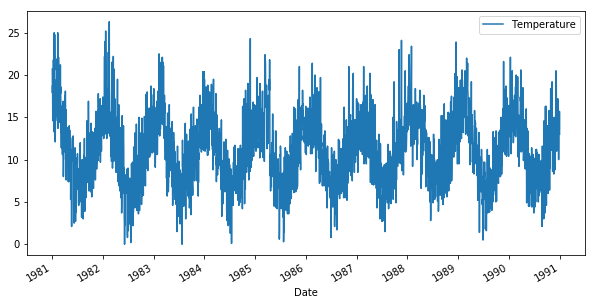

In [8]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [9]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [10]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [11]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [12]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [13]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [14]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


Note: you may want to use `keras.preprocessing.sequence.TimeseriesGenerator` or `tf.data.Dataset.window()` instead.

## 1.4) Split the dataset

Split this dataset into three periods: training (1981-1986), validation (1987-1988) and testing (1989-1990).

In [15]:
#X_train, y_train = ...
#X_valid, y_valid = ...
#X_test, y_test = ...

## 1.5) Reshape the inputs for the RNN

Keras and TensorFlow expect a 3D NumPy array for any sequence. Its shape should be (number of instances, number of time steps, number of features per time step). Since this is a univariate time series, the last dimension is 1. Reshape the input features to get 3D arrays:

In [16]:
#X_train_3D = ...
#X_valid_3D = ...
#X_test_3D = ...

## 1.6) Build some baseline models

Build some baseline models (at least one) and evaluate them on the validation set, using the Mean Absolute Error (MAE). For example:

* a naive model, that just predicts the last known value.
* an EMA model that predicts an exponential moving average of the last 48 hours (you can try to find the best span).
* a linear model.

Optional: plot the predictions.

## 1.7) Build a simple RNN

Using Keras, build a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron. Train the model for 200 epochs with a batch size of 200, using Stochastic Gradient Descent with an learning rate of 0.005. Make sure to print the validation loss during training.

Hints:

* Create a `Sequential` model.
* Add two `SimpleRNN` layers, with 100 units each. The first should return sequences but not the second. Indeed, in a Seq2Vec model, the last RNN layer should not return sequences. The first layer should specify the input shape (i.e., the shape of a single input sequence).
* Use the MSE as the loss.
* Call the model's `compile()` method, passing it an `SGD` instance with `lr=0.005`.
* Call the model's `fit()` method, with the inputs and targets, number of epochs, batch size and validation data.

In [17]:
#model1 = ...

## 1.8) Plot the history

Recall that you can simply use `pd.DataFrame(history.history).plot()`.

## 1.9) Evaluate the model

Evaluate your RNN on the validation set, using the MAE. Try training your model again using the Huber loss and see if you get better performance.

In [ ]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

## 1.10) Plot the predictions

Make predictions on the validation set and plot them. Compare them to the targets and the baseline predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 1 – Solution

## 1.1) Load the data

Let's start with a simple univariate time series: the daily temperatures in Melbourne from 1981 to 1990 ([source](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990)).

In [15]:
temps = pd.read_csv("datasets/daily-minimum-temperatures-in-me.csv",
                    parse_dates=[0], index_col=0)

In [16]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [17]:
temps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


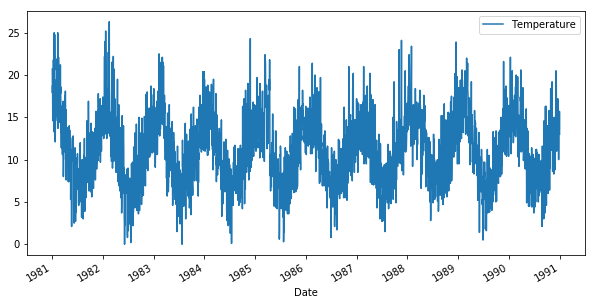

In [18]:
temps.plot(figsize=(10,5))
plt.show()

## 1.2) Prepare the data

A few dates are missing, for example December 31st, 1984:

In [19]:
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1985-01-01,13.3
1985-01-02,15.2


Let's ensure there's one row per day, filling missing values with the previous valid value:

In [20]:
temps = temps.asfreq("1D", method="ffill")
temps.loc["1984-12-29":"1985-01-02"]

,Temperature
Date,
1984-12-29,16.0
1984-12-30,16.4
1984-12-31,16.4
1985-01-01,13.3
1985-01-02,15.2


Alternatively, we could have interpolated using `temps.interpolate()`.

## 1.3) Add the shifted columns

Next, let's create a function to add lag columns:

In [21]:
def add_lags(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

In [22]:
add_lags(temps, times=(-2, -1, 0, +2)).head(10)

,t-2,t-1,t,t+2
,Temperature,Temperature,Temperature,Temperature
Date,,,,
1981-01-01,NaN,NaN,20.7,18.8
1981-01-02,NaN,20.7,17.9,14.6
1981-01-03,20.7,17.9,18.8,15.8
1981-01-04,17.9,18.8,14.6,15.8
1981-01-05,18.8,14.6,15.8,15.8
1981-01-06,14.6,15.8,15.8,17.4
1981-01-07,15.8,15.8,15.8,21.8
1981-01-08,15.8,15.8,17.4,20.0


We will try to predict the temperature in 5 days (t+5) using the temperatures from the last 30 days (t-29 to t):

In [23]:
X = add_lags(temps, times=range(-30+1,1)).iloc[30:-5]
y = add_lags(temps, times=[5]).iloc[30:-5]

In [24]:
X.head()

,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,...,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,12.1,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4
1981-02-01,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.4,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3
1981-02-02,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,16.0,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8
1981-02-03,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,16.5,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9
1981-02-04,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,18.7,19.4,17.2,15.5,15.1,15.4,15.3,18.8,21.9,19.9


In [25]:
y.head()

,t+5
,Temperature
Date,
1981-01-31,16.6
1981-02-01,16.8
1981-02-02,14.6
1981-02-03,17.1
1981-02-04,25.0


## 1.4) Split the dataset

Let's split this dataset into three periods: training, validation and testing:

In [26]:
train_slice = slice(None, "1986-12-25")
valid_slice = slice("1987-01-01", "1988-12-25")
test_slice = slice("1989-01-01", None)

In [27]:
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_valid, y_valid = X.loc[valid_slice], y.loc[valid_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

## 1.5) Reshape the inputs for the RNN

Now let's create a function to reshape the multilevel DataFrames to 3D numpy arrays to feed to an RNN:

In [28]:
def multilevel_df_to_ndarray(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

In [29]:
X_train_3D = multilevel_df_to_ndarray(X_train)
X_valid_3D = multilevel_df_to_ndarray(X_valid)
X_test_3D = multilevel_df_to_ndarray(X_test)

In [30]:
X_train.shape

(2155, 30)

In [31]:
X_train_3D.shape

(2155, 30, 1)

## 1.6) Build some baseline models

Now let's evaluate some basic strategies, to get some baselines:

In [32]:
from sklearn.metrics import mean_absolute_error

In [33]:
def naive(X):
    return X.iloc[:, -1]

In [34]:
y_pred_naive = naive(X_valid)

In [35]:
mean_absolute_error(y_valid, y_pred_naive)

2.976551724137931

In [36]:
def ema(X, span):
    return X.T.ewm(span=span).mean().T.iloc[:, -1]

In [37]:
y_pred_ema = ema(X_valid, span=10)

In [38]:
mean_absolute_error(y_valid, y_pred_ema)

2.3581754113889133

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
y_pred_linear = lin_reg.predict(X_valid)

Let's plot these predictions:

In [42]:
def plot_predictions(*named_predictions, start=None, end=None, **kwargs):
    day_range = slice(start, end)
    plt.figure(figsize=(10,5))
    for name, y_pred in named_predictions:
        if hasattr(y_pred, "values"):
            y_pred = y_pred.values
        plt.plot(y_pred[day_range], label=name, **kwargs)
    plt.legend()
    plt.show()

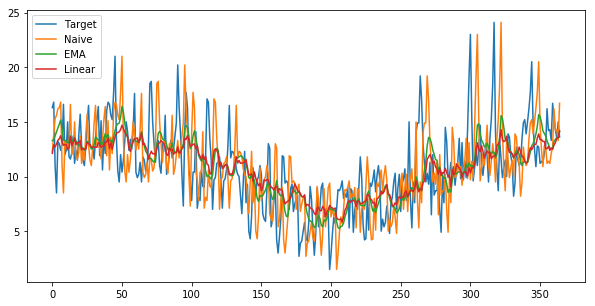

In [43]:
plot_predictions(("Target", y_valid),
                 ("Naive", y_pred_naive),
                 ("EMA", y_pred_ema),
                 ("Linear", y_pred_linear),
                 end=365)

## 1.7) Build a simple RNN

Let's create a simple 2-layer RNN with 100 neurons per layer, plus a dense layer with a single neuron:

In [44]:
input_shape = X_train_3D.shape[1:]
input_shape

(30, 1)

In [45]:
mean_absolute_error(y_valid, y_pred_linear)

2.2606549856754157

In [46]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(50))
model1.add(keras.layers.Dense(1))
model1.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

In [47]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, <class 'pandas.core.frame.DataFrame'>

## 1.8) Plot the history

In [37]:
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, 0, 20])
    plt.legend()
    plt.show()

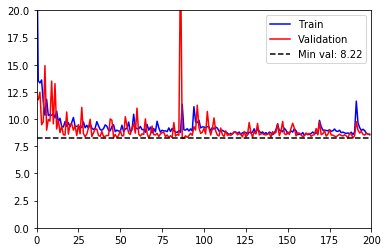

In [38]:
plot_history(history1)

## 1.9) Evaluate the model

In [39]:
model1.evaluate(X_valid_3D, y_valid)

725/725 [==============================] - 0s 119us/sample - loss: 8.6227 - mae: 2.2919


[8.622721843061775, 2.2919292]

In [40]:
def huber_loss(y_true, y_pred, max_grad=1.):
    err = tf.abs(y_true - y_pred, name='abs')
    mg = tf.constant(max_grad, name='max_grad')
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

In [41]:
model1 = keras.models.Sequential()
model1.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model1.add(keras.layers.SimpleRNN(100))
model1.add(keras.layers.Dense(1))
model1.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005), metrics=["mae"])

In [42]:
history1 = model1.fit(X_train_3D, y_train, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, y_valid))

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 1s 375us/sample - loss: 6.6782 - mae: 7.1677 - val_loss: 3.9545 - val_mae: 4.4388
Epoch 2/200
2155/2155 [==============================] - 0s 156us/sample - loss: 3.1696 - mae: 3.6389 - val_loss: 2.6352 - val_mae: 3.1010
Epoch 3/200
2155/2155 [==============================] - 0s 162us/sample - loss: 2.6387 - mae: 3.1031 - val_loss: 2.3945 - val_mae: 2.8533
Epoch 4/200
2155/2155 [==============================] - 0s 159us/sample - loss: 2.5314 - mae: 2.9939 - val_loss: 2.3181 - val_mae: 2.7746
Epoch 5/200
2155/2155 [==============================] - 0s 153us/sample - loss: 2.4520 - mae: 2.9141 - val_loss: 2.2379 - val_mae: 2.6933
Epoch 6/200
2155/2155 [==============================] - 0s 166us/sample - loss: 2.3543 - mae: 2.8163 - val_loss: 2.1592 - val_mae: 2.6179
Epoch 7/200
2155/2155 [==============================] - 0s 158us/sample - loss: 2.2491 - mae: 2.7125 - val_loss: 2.061

2155/2155 [==============================] - 0s 150us/sample - loss: 1.8591 - mae: 2.3087 - val_loss: 1.7952 - val_mae: 2.2434
Epoch 118/200
2155/2155 [==============================] - 0s 145us/sample - loss: 1.8664 - mae: 2.3200 - val_loss: 1.7616 - val_mae: 2.2180
Epoch 119/200
2155/2155 [==============================] - 0s 153us/sample - loss: 1.8486 - mae: 2.3026 - val_loss: 1.7599 - val_mae: 2.2161
Epoch 120/200
2155/2155 [==============================] - 0s 158us/sample - loss: 1.8461 - mae: 2.2979 - val_loss: 1.7664 - val_mae: 2.2205
Epoch 121/200
2155/2155 [==============================] - 0s 150us/sample - loss: 1.8540 - mae: 2.3058 - val_loss: 1.7748 - val_mae: 2.2290
Epoch 122/200
2155/2155 [==============================] - 0s 181us/sample - loss: 1.8652 - mae: 2.3162 - val_loss: 1.7633 - val_mae: 2.2171
Epoch 123/200
2155/2155 [==============================] - 0s 161us/sample - loss: 1.8379 - mae: 2.2928 - val_loss: 1.7647 - val_mae: 2.2167
Epoch 124/200
2155/2155 [==

In [43]:
model1.evaluate(X_valid_3D, y_valid)

725/725 [==============================] - 0s 152us/sample - loss: 1.7858 - mae: 2.2337


[1.7858449761620883, 2.2337165]

## 1.10) Plot the predictions

In [44]:
y_pred_rnn1 = model1.predict(X_valid_3D)

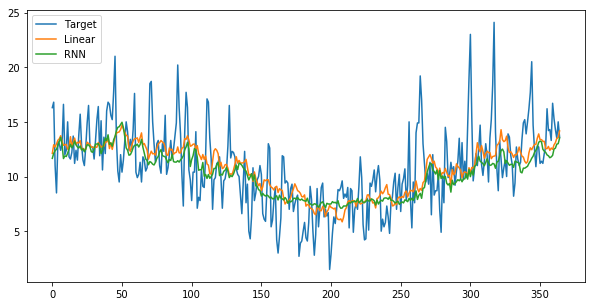

In [45]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn1),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 2 – Forecasting the shifted sequence (Seq2Seq)

Now let's predict temperatures for 30 days (from t-24 to t+5) instead of just one.

## 2.1) Define the 3D targets for training, validation and testing

In [ ]:
#Y_train_3D = ...
#Y_valid_3D = ...
#Y_test_3D = ...

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5). Create an `mae_last_step()` function that computes the MAE based on the final time step.

## 2.3) Build a Seq2Seq model

Build a Seq2Seq model and compile it, using the Huber Loss, and using the last step MAE as the metric. Use SGD with a learning rate of 0.01. Hint: the layers are the same as earlier, except that the last RNN layer has `return_sequences=False`.

## 2.4) Train the model

Fit the model as earlier (but with the 3D targets). Again, evaluate the model and plot the predictions.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 2 – Solution

## 2.1) Define the 3D targets for training, validation and testing

In [46]:
Y = add_lags(temps, times=range(-24, 5+1)).iloc[30:-5]
Y_train = Y.loc[train_slice]
Y_valid = Y.loc[valid_slice]
Y_test = Y.loc[test_slice]
Y_train_3D = multilevel_df_to_ndarray(Y_train)
Y_valid_3D = multilevel_df_to_ndarray(Y_valid)
Y_test_3D = multilevel_df_to_ndarray(Y_test)

## 2.2) Define an `mae_last_step()` function

For the final evaluation, we only want to look at the final time step (t+5):

In [47]:
K = keras.backend

def mae_last_step(Y_true, Y_pred):
    return K.mean(K.abs(Y_pred[:, -1] - Y_true[:, -1]))

## 2.3) Build a Seq2Seq model

In [48]:
model2 = keras.models.Sequential()
model2.add(keras.layers.SimpleRNN(100, return_sequences=True, input_shape=input_shape))
model2.add(keras.layers.SimpleRNN(100, return_sequences=True))
model2.add(keras.layers.Dense(1))
model2.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

## 2.4) Train the model

In [49]:
history2 = model2.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D))

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 1s 369us/sample - loss: 5.6181 - mae_last_step: 5.9169 - val_loss: 2.8517 - val_mae_last_step: 3.2437
Epoch 2/200
2155/2155 [==============================] - 0s 169us/sample - loss: 2.7573 - mae_last_step: 3.1298 - val_loss: 2.3785 - val_mae_last_step: 2.8192
Epoch 3/200
2155/2155 [==============================] - 0s 163us/sample - loss: 2.5150 - mae_last_step: 2.8790 - val_loss: 2.1623 - val_mae_last_step: 2.5458
Epoch 4/200
2155/2155 [==============================] - 0s 194us/sample - loss: 2.2737 - mae_last_step: 2.6428 - val_loss: 2.0069 - val_mae_last_step: 2.3976
Epoch 5/200
2155/2155 [==============================] - 0s 170us/sample - loss: 2.2181 - mae_last_step: 2.5834 - val_loss: 2.1017 - val_mae_last_step: 2.5555
Epoch 6/200
2155/2155 [==============================] - 0s 167us/sample - loss: 2.1973 - mae_last_step: 2.5667 - val_loss: 1.9492 - val_mae_last_step: 2.3426

Epoch 52/200
2155/2155 [==============================] - 0s 164us/sample - loss: 1.9905 - mae_last_step: 2.4120 - val_loss: 1.8614 - val_mae_last_step: 2.2804
Epoch 53/200
2155/2155 [==============================] - 0s 189us/sample - loss: 1.9270 - mae_last_step: 2.3299 - val_loss: 1.8412 - val_mae_last_step: 2.2612
Epoch 54/200
2155/2155 [==============================] - 0s 156us/sample - loss: 1.9235 - mae_last_step: 2.3248 - val_loss: 1.8506 - val_mae_last_step: 2.2641
Epoch 55/200
2155/2155 [==============================] - 0s 166us/sample - loss: 1.9701 - mae_last_step: 2.3375 - val_loss: 1.8477 - val_mae_last_step: 2.2781
Epoch 56/200
2155/2155 [==============================] - 0s 188us/sample - loss: 1.9254 - mae_last_step: 2.3251 - val_loss: 1.8515 - val_mae_last_step: 2.2912
Epoch 57/200
2155/2155 [==============================] - 0s 169us/sample - loss: 1.9484 - mae_last_step: 2.3552 - val_loss: 1.8560 - val_mae_last_step: 2.2998
Epoch 58/200
2155/2155 [================

Epoch 154/200
2155/2155 [==============================] - 0s 197us/sample - loss: 1.9194 - mae_last_step: 2.3131 - val_loss: 1.8490 - val_mae_last_step: 2.2378
Epoch 155/200
2155/2155 [==============================] - 0s 164us/sample - loss: 1.8956 - mae_last_step: 2.2916 - val_loss: 1.8135 - val_mae_last_step: 2.2355
Epoch 156/200
2155/2155 [==============================] - 0s 164us/sample - loss: 1.8940 - mae_last_step: 2.2945 - val_loss: 1.8432 - val_mae_last_step: 2.2650
Epoch 157/200
2155/2155 [==============================] - 0s 163us/sample - loss: 1.8971 - mae_last_step: 2.2849 - val_loss: 1.8267 - val_mae_last_step: 2.2615
Epoch 158/200
2155/2155 [==============================] - 0s 164us/sample - loss: 1.9265 - mae_last_step: 2.3342 - val_loss: 1.8122 - val_mae_last_step: 2.2419
Epoch 159/200
2155/2155 [==============================] - 0s 166us/sample - loss: 1.8890 - mae_last_step: 2.2819 - val_loss: 1.8180 - val_mae_last_step: 2.2642
Epoch 160/200
2155/2155 [=========

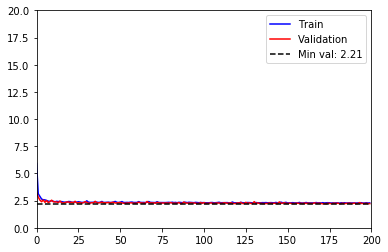

In [51]:
plot_history(history2, loss="mae_last_step")

In [52]:
model2.evaluate(X_valid_3D, Y_valid_3D)

725/725 [==============================] - 0s 139us/sample - loss: 1.8094 - mae_last_step: 2.2376


[1.8094089379803888, 2.2375774]

In [53]:
y_pred_rnn2 = model2.predict(X_valid_3D)[:, -1]

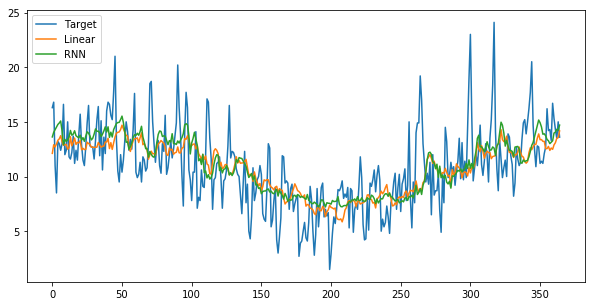

In [54]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn2),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 3 – LSTM and GRU

## 3.1) Build, train and evaluate a Seq2Seq LSTM

Train the same model as earlier but using `LSTM` or `GRU` instead of `SimpleRNN`. You can also try reducing the learning rate when the validation loss reaches a plateau, using the `ReduceLROnPlateau` callback.

## 3.2) Add $\ell_2$ regularization

Add $\ell_2$ regularization to your RNN, using the layers' `kernel_regularizer` and `recurrent_regularizer` arguments, and the `l2()` function in `keras.regularizers`. Tip: use the `partial()` function in the `functools` package to avoid repeating the same arguments again and again.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 3 – Solution

## 3.1) Build, train and evaluate a Seq2Seq LSTM

You can try replacing `LSTM` with `GRU`.

In [55]:
model3 = keras.models.Sequential()
model3.add(keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape))
model3.add(keras.layers.LSTM(100, return_sequences=True))
model3.add(keras.layers.Dense(1))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [56]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=200,
                      validation_data=(X_valid_3D, Y_valid_3D),
                      callbacks=[keras.callbacks.ReduceLROnPlateau(verbose=1)])

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 2s 735us/sample - loss: 9.0115 - mae_last_step: 9.1380 - val_loss: 7.6200 - val_mae_last_step: 7.5634
Epoch 2/200
2155/2155 [==============================] - 1s 442us/sample - loss: 6.1082 - mae_last_step: 5.8739 - val_loss: 4.9602 - val_mae_last_step: 4.7153
Epoch 3/200
2155/2155 [==============================] - 1s 439us/sample - loss: 4.1355 - mae_last_step: 3.8768 - val_loss: 3.4802 - val_mae_last_step: 3.2701
Epoch 4/200
2155/2155 [==============================] - 1s 479us/sample - loss: 3.3409 - mae_last_step: 3.2031 - val_loss: 3.0018 - val_mae_last_step: 2.9163
Epoch 5/200
2155/2155 [==============================] - 1s 454us/sample - loss: 3.1396 - mae_last_step: 3.1308 - val_loss: 2.8819 - val_mae_last_step: 2.8913
Epoch 6/200
2155/2155 [==============================] - 1s 432us/sample - loss: 3.0828 - mae_last_step: 3.1228 - val_loss: 2.8312 - val_mae_last_step: 2.8789

Epoch 52/200
2155/2155 [==============================] - 1s 462us/sample - loss: 2.0754 - mae_last_step: 2.3016 - val_loss: 2.0075 - val_mae_last_step: 2.2539
Epoch 53/200
2155/2155 [==============================] - 1s 466us/sample - loss: 2.0741 - mae_last_step: 2.3068 - val_loss: 1.9805 - val_mae_last_step: 2.2147
Epoch 54/200
2155/2155 [==============================] - 1s 453us/sample - loss: 2.0663 - mae_last_step: 2.2830 - val_loss: 2.0093 - val_mae_last_step: 2.2578
Epoch 55/200
2155/2155 [==============================] - 1s 467us/sample - loss: 2.0813 - mae_last_step: 2.3283 - val_loss: 1.9833 - val_mae_last_step: 2.2481
Epoch 56/200
2155/2155 [==============================] - 1s 479us/sample - loss: 2.0620 - mae_last_step: 2.2877 - val_loss: 1.9762 - val_mae_last_step: 2.2122
Epoch 57/200
2155/2155 [==============================] - 1s 461us/sample - loss: 2.0713 - mae_last_step: 2.3094 - val_loss: 1.9704 - val_mae_last_step: 2.2277
Epoch 58/200
2155/2155 [================

Epoch 154/200
2155/2155 [==============================] - 1s 460us/sample - loss: 1.9721 - mae_last_step: 2.2923 - val_loss: 1.8738 - val_mae_last_step: 2.2311
Epoch 155/200
2155/2155 [==============================] - 1s 432us/sample - loss: 1.9482 - mae_last_step: 2.2754 - val_loss: 1.8757 - val_mae_last_step: 2.1936
Epoch 156/200
2155/2155 [==============================] - 1s 461us/sample - loss: 1.9486 - mae_last_step: 2.2755 - val_loss: 1.8718 - val_mae_last_step: 2.2195
Epoch 157/200
2155/2155 [==============================] - 1s 459us/sample - loss: 1.9423 - mae_last_step: 2.2793 - val_loss: 1.8732 - val_mae_last_step: 2.2430
Epoch 158/200
2155/2155 [==============================] - 1s 494us/sample - loss: 1.9603 - mae_last_step: 2.2812 - val_loss: 1.8731 - val_mae_last_step: 2.2148
Epoch 159/200
2155/2155 [==============================] - 1s 461us/sample - loss: 1.9547 - mae_last_step: 2.2825 - val_loss: 1.8761 - val_mae_last_step: 2.2616
Epoch 160/200
2155/2155 [=========

In [57]:
model3.evaluate(X_valid_3D, Y_valid_3D)

725/725 [==============================] - 0s 291us/sample - loss: 1.8574 - mae_last_step: 2.2430


[1.8573907845595787, 2.2430065]

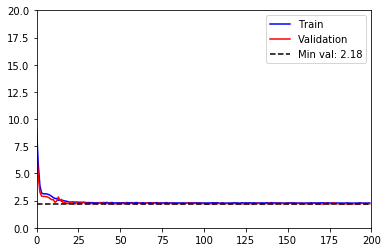

In [58]:
plot_history(history3, loss="mae_last_step")

In [59]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

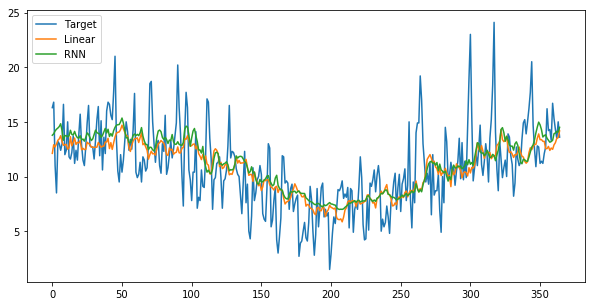

In [60]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

## 3.2) Add $\ell_2$ regularization

In [61]:
from functools import partial

In [62]:
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

In [63]:
model3 = keras.models.Sequential()
model3.add(RegularizedLSTM(100, input_shape=input_shape))
model3.add(RegularizedLSTM(100))
model3.add(keras.layers.Dense(1))
model3.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.01),
               metrics=[mae_last_step])

In [64]:
history3 = model3.fit(X_train_3D, Y_train_3D, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, Y_valid_3D))

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 2s 940us/sample - loss: 7.7622 - mae_last_step: 7.6717 - val_loss: 5.4321 - val_mae_last_step: 5.2936
Epoch 2/200
2155/2155 [==============================] - 1s 561us/sample - loss: 4.0095 - mae_last_step: 3.7558 - val_loss: 3.1087 - val_mae_last_step: 2.9331
Epoch 3/200
2155/2155 [==============================] - 1s 521us/sample - loss: 3.1588 - mae_last_step: 3.1321 - val_loss: 2.8678 - val_mae_last_step: 2.8642
Epoch 4/200
2155/2155 [==============================] - 1s 530us/sample - loss: 3.0715 - mae_last_step: 3.1258 - val_loss: 2.7944 - val_mae_last_step: 2.8270
Epoch 5/200
2155/2155 [==============================] - 1s 550us/sample - loss: 2.9704 - mae_last_step: 3.0080 - val_loss: 2.6905 - val_mae_last_step: 2.6747
Epoch 6/200
2155/2155 [==============================] - 1s 544us/sample - loss: 2.8225 - mae_last_step: 2.8519 - val_loss: 2.5876 - val_mae_last_step: 2.5771

Epoch 52/200
2155/2155 [==============================] - 1s 511us/sample - loss: 2.0267 - mae_last_step: 2.2757 - val_loss: 1.9413 - val_mae_last_step: 2.1845
Epoch 53/200
2155/2155 [==============================] - 1s 503us/sample - loss: 2.0242 - mae_last_step: 2.2956 - val_loss: 1.9375 - val_mae_last_step: 2.1951
Epoch 54/200
2155/2155 [==============================] - 1s 503us/sample - loss: 2.0226 - mae_last_step: 2.2906 - val_loss: 1.9391 - val_mae_last_step: 2.2286
Epoch 55/200
2155/2155 [==============================] - 1s 511us/sample - loss: 2.0223 - mae_last_step: 2.2918 - val_loss: 1.9483 - val_mae_last_step: 2.2110
Epoch 56/200
2155/2155 [==============================] - 1s 510us/sample - loss: 2.0147 - mae_last_step: 2.2801 - val_loss: 1.9308 - val_mae_last_step: 2.1903
Epoch 57/200
2155/2155 [==============================] - 1s 511us/sample - loss: 2.0327 - mae_last_step: 2.2996 - val_loss: 1.9385 - val_mae_last_step: 2.2733
Epoch 58/200
2155/2155 [================

Epoch 154/200
2155/2155 [==============================] - 1s 553us/sample - loss: 1.9405 - mae_last_step: 2.2716 - val_loss: 1.8706 - val_mae_last_step: 2.1990
Epoch 155/200
2155/2155 [==============================] - 1s 542us/sample - loss: 1.9450 - mae_last_step: 2.2644 - val_loss: 1.8721 - val_mae_last_step: 2.2330
Epoch 156/200
2155/2155 [==============================] - 1s 530us/sample - loss: 1.9395 - mae_last_step: 2.2728 - val_loss: 1.8652 - val_mae_last_step: 2.2327
Epoch 157/200
2155/2155 [==============================] - 1s 532us/sample - loss: 1.9368 - mae_last_step: 2.2687 - val_loss: 1.8610 - val_mae_last_step: 2.1946
Epoch 158/200
2155/2155 [==============================] - 1s 507us/sample - loss: 1.9387 - mae_last_step: 2.2710 - val_loss: 1.8565 - val_mae_last_step: 2.2158
Epoch 159/200
2155/2155 [==============================] - 1s 542us/sample - loss: 1.9373 - mae_last_step: 2.2646 - val_loss: 1.8578 - val_mae_last_step: 2.1835
Epoch 160/200
2155/2155 [=========

In [65]:
model3.evaluate(X_valid_3D, Y_valid_3D)

725/725 [==============================] - 0s 284us/sample - loss: 1.8673 - mae_last_step: 2.2503


[1.8673243473316061, 2.2503166]

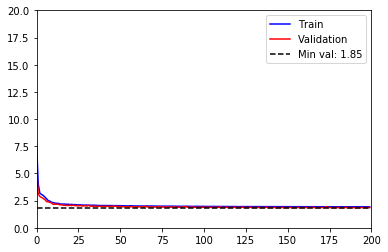

In [66]:
plot_history(history3)

In [67]:
y_pred_rnn3 = model3.predict(X_valid_3D)[:, -1]

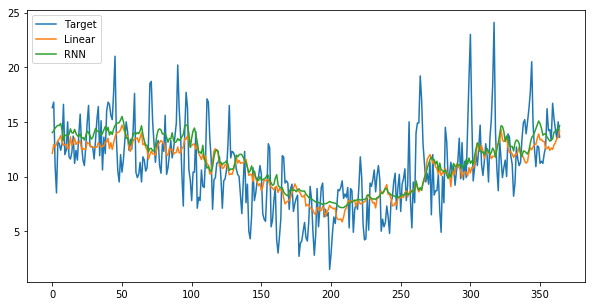

In [68]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn3),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 4 – Preprocessing with 1D-ConvNets

At the beginning of your sequential model, add a `Conv1D` layer with 32 kernels of size 5, a `MaxPool1D` layer with pool size 5 and strides 2. Train and evaluate the model.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 4 – Solution

In [51]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Conv1D(32, kernel_size=5, input_shape=input_shape))
model4.add(keras.layers.MaxPool1D(pool_size=5, strides=2))
model4.add(keras.layers.LSTM(32, return_sequences=True))
model4.add(keras.layers.LSTM(32))
model4.add(keras.layers.Dense(1))
model4.compile(loss=huber_loss, optimizer=keras.optimizers.SGD(lr=0.005))

NameError: name 'input_shape' is not defined

In [70]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 32)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
unified_lstm_4 (UnifiedLSTM) (None, 11, 32)            8320      
_________________________________________________________________
unified_lstm_5 (UnifiedLSTM) (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [71]:
history4 = model4.fit(X_train_3D, y_train, epochs=200, batch_size=100,
                      validation_data=(X_valid_3D, y_valid))

Train on 2155 samples, validate on 725 samples
Epoch 1/200
2155/2155 [==============================] - 1s 402us/sample - loss: 9.6770 - val_loss: 9.3224
Epoch 2/200
2155/2155 [==============================] - 0s 102us/sample - loss: 8.1520 - val_loss: 7.8037
Epoch 3/200
2155/2155 [==============================] - 0s 102us/sample - loss: 6.6832 - val_loss: 6.2662
Epoch 4/200
2155/2155 [==============================] - 0s 107us/sample - loss: 5.2732 - val_loss: 4.8447
Epoch 5/200
2155/2155 [==============================] - 0s 101us/sample - loss: 4.0943 - val_loss: 3.7414
Epoch 6/200
2155/2155 [==============================] - 0s 105us/sample - loss: 3.3438 - val_loss: 3.0790
Epoch 7/200
2155/2155 [==============================] - 0s 105us/sample - loss: 2.9731 - val_loss: 2.7521
Epoch 8/200
2155/2155 [==============================] - 0s 106us/sample - loss: 2.8104 - val_loss: 2.5951
Epoch 9/200
2155/2155 [==============================] - 0s 102us/sample - loss: 2.7124 - val_los

2155/2155 [==============================] - 0s 108us/sample - loss: 1.8017 - val_loss: 1.7467
Epoch 152/200
2155/2155 [==============================] - 0s 104us/sample - loss: 1.8375 - val_loss: 1.7988
Epoch 153/200
2155/2155 [==============================] - 0s 101us/sample - loss: 1.8072 - val_loss: 1.7450
Epoch 154/200
2155/2155 [==============================] - 0s 100us/sample - loss: 1.7871 - val_loss: 2.1001
Epoch 155/200
2155/2155 [==============================] - 0s 101us/sample - loss: 1.8974 - val_loss: 1.8392
Epoch 156/200
2155/2155 [==============================] - 0s 102us/sample - loss: 1.8277 - val_loss: 1.8558
Epoch 157/200
2155/2155 [==============================] - 0s 106us/sample - loss: 1.8286 - val_loss: 1.7560
Epoch 158/200
2155/2155 [==============================] - 0s 104us/sample - loss: 1.8196 - val_loss: 1.8631
Epoch 159/200
2155/2155 [==============================] - 0s 100us/sample - loss: 1.8217 - val_loss: 1.7571
Epoch 160/200
2155/2155 [========

In [72]:
model4.evaluate(X_valid_3D, y_valid)

725/725 [==============================] - 0s 77us/sample - loss: 1.7591


1.7590992352058148

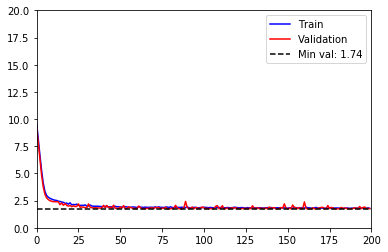

In [73]:
plot_history(history4)

In [75]:
y_pred_rnn4 = model4.predict(X_valid_3D)[:, -1]

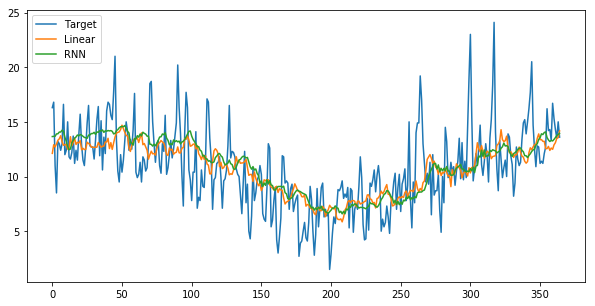

In [77]:
plot_predictions(("Target", y_valid),
                 ("Linear", y_pred_linear),
                 ("RNN", y_pred_rnn4),
                 end=365)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercice 5 – Sequence classification

Let's load the IMDB movie reviews, for binary sentiment analysis (positive review or negative review):

We only want the 10,000 most common words:

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

Let's also get the word index (word to word id):

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

And let's create a reverse index (word id to word). Three special word ids are added:

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

Let's write a little function to decode reviews:

In [ ]:
def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's look at a review:

In [ ]:
decode_review(X_train[0])

It seems very positive, let's look at the target (0=negative review, 1=positive review):

In [ ]:
y_train[0]

And another review:

In [ ]:
decode_review(X_train[1])

Very negative! Let's check the target:

In [ ]:
y_train[1]

## 5.1) Train a baseline model

Train and evaluate a baseline model using ScikitLearn. You will need to create a pipeline with a `CountVectorizer`, a `TfidfTransformer` and an `SGDClassifier`. The `CountVectorizer` transformer expects text as input, so let's create a text version of the training set and test set:

In [ ]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

## 5.2) Create a sequence classifier

Create a sequence classifier using Keras:
* Use `keras.preprocessing.sequence.pad_sequences()` to preprocess `X_train`: this will create a 2D array of 25,000 rows (one per review) and `maxlen=500` columns. Reviews longer than 500 words will be cropped, while reviews shorter 
than 500 words will be padded with zeros.
* The first layer in your model should be an `Embedding` layer, with `input_dim=num_words` and `output_dim=10`. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batchs of shape (batch size, 500, 10).
* Add one or more LSTM layers with 32 neurons each.
* The output layer should be a Dense layer with a sigmoid activation function, since this is a binary classification problem.
* When compiling the model, you should use the `binary_crossentropy` loss.
* Fit the model for 10 epochs, using a batch size of 128 and `validation_split=0.2`.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercice 5 – Solution

## 5.1) Train a baseline model

In [50]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

NameError: name 'decode_review' is not defined

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=50)),
])

In [ ]:
pipeline.fit(X_train_text, y_train)

In [ ]:
pipeline.score(X_test_text, y_test)

We get 88.5% accuracy, that's not too bad. But don't forget to check the ratio of positive reviews:

In [ ]:
y_test.mean()

Let's try our model:

In [ ]:
pipeline.predict(["this movie was really awesome"])

## 5.2) Create a sequence classifier

In [49]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

ValueError: invalid literal for int() with base 10: 't-29'

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
model.evaluate(X_test_trim, y_test)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

# Exercise 6 – Bidirectional RNN

Update the previous sequence classification model to use a bidirectional LSTM. For this, you just need to wrap the LSTM layer in a `Bidirectional` layer. If the model overfits, try adding a dropout layer.

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

# Exercise 6 – Solution

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

NameError: name 'num_words' is not defined

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
model.evaluate(X_test_trim, y_test)